# Tanzania hazard map

This notebook takes different shape inputs and combines them to create a hazard vulnerability map.

In [15]:
#expofile = "TZA_buildings_exposure_20200224.dbf" #contains location id and positions
# The one above is not found in the data folder
expofile = "TZA_buildings_exposure_20200731.dbf" #contains location id and positions  - present
#exposure

# exposure with breakdown
# present
expobfile = "TZA_buildings_exposure_breakdown_20200731.dbf" #contains location id and breakdown of number of each house type
#volcP = ["kyejo", "meru"]
#volcL = ["lengai", "ngozi", "rungwe"]
# present
volcfile = "World_Volcanoes_Smithsonian_Institution_GVP.shp" #point locations of volcanoes
volcnames = ["Lengai, Ol Doinyo", "Meru", "Ngozi", "Rungwe", "Kyejo"] #names of volcanoes in Smithsonian shp

# 1 in 100, 1 in 200 in the file
floodratio = 100 #selects from different flood tifs
floodtypes = ["FD", "FU", "P"] #selects from different flood tifs
# in the Seismic folder
eqfile = "hazard_map_mean_tanzania.dbf" #contains earthquake information

Set out imports and functions to use later

*dbf_to_df* reads a dbf file, and converts it to a pandas dataframe

*getbreakdown* does dbf_to_df, then selects the OBJECTID, CONTYPE, and TOT_CNT columns to create a table where the columns are the CONTYPE (building type), and the values in the table are the counts. (If there are two values for an OBJECTID-CONTYPE pair then the maximum is used, missing values are filled with 0s.) Row sums are calculated, then divided so that the total of each row is 1, so values are proportions of each building type per location.

In [16]:
import geopandas as gpd
import pandas as pd
import numpy as np
import gdal

def dbf_to_df(filename):
    return pd.DataFrame(gpd.read_file(filename))
    
    
def getbreakdown(filename):
    breakdwn = (dbf_to_df(filename)[['OBJECTID', 'CONTYPE', 'TOT_CNT']]
        .pivot_table(index='OBJECTID', columns='CONTYPE', values='TOT_CNT', aggfunc=np.max).fillna(0))
    breakdwn['SUM'] = breakdwn.sum(axis=1)
    breakdwn = breakdwn.divide(breakdwn['SUM'], axis=0).drop('SUM', axis=1)
    return breakdwn

# Volcano

Load and combine the volcano shp files.

pyroclastic: set to 5 if under 15km from volcano centre, 3 if 15-30km, 1 if 30-50km

lahar: set to 5 if under 50km from volcano centre, 3 if 50-100km, 1 if 100-200km

In [17]:
volcs = gpd.read_file(volcfile)
volcs = volcs[volcs.Volc_Name.isin(volcnames)]
def to_bdy(gdf):
    gdfg = gdf.geometry.unary_union   # geo df geometry
    return gpd.GeoDataFrame(geometry=[gdfg], crs=gdf.crs)

#generate circles with buffer to get each radius, then take difference for each assignment
#pyroclastic
# Indexes - get set later on - how close to volcano
volcsP5 = to_bdy(volcs.to_crs("EPSG:32634").buffer(15000).to_crs("EPSG:4326"))    # Highest hazard - closest 
volcsP3 = to_bdy(volcs.to_crs("EPSG:32634").buffer(30000).to_crs("EPSG:4326"))
volcsP1 = to_bdy(volcs.to_crs("EPSG:32634").buffer(50000).to_crs("EPSG:4326"))

volcsP1 = gpd.overlay(volcsP1, volcsP3, how='difference') #P1 is 50km circle WITHOUT 30km circle
volcsP3 = gpd.overlay(volcsP3, volcsP5, how='difference') 

#lahar
volcsL5 = to_bdy(volcs.to_crs("EPSG:32634").buffer(50000).to_crs("EPSG:4326"))
volcsL3 = to_bdy(volcs.to_crs("EPSG:32634").buffer(100000).to_crs("EPSG:4326"))
volcsL1 = to_bdy(volcs.to_crs("EPSG:32634").buffer(200000).to_crs("EPSG:4326"))

volcsL1 = gpd.overlay(volcsL1, volcsL3, how='difference')
volcsL3 = gpd.overlay(volcsL3, volcsL5, how='difference')

#volcsL = gpd.GeoDataFrame(volcsL1, volcsL3, volcsL5)

In [18]:
volcsL1['lah'] = 1. #set values before combining
volcsL3['lah'] = 3.
volcsL5['lah'] = 5.
volcsP1['pyr'] = 1.
volcsP3['pyr'] = 3.
volcsP5['pyr'] = 5.

volcsL = volcsL1.append(volcsL3).append(volcsL5) #combine all Lahar together
volcsP = volcsP1.append(volcsP3).append(volcsP5) # combine pyro


# old code (used shp files for volcano basins)
def to_bdy(gdf):
    gdfg = gdf.geometry.unary_union
    return gpd.GeoDataFrame(geometry=[gdfg], crs=gdf.crs)


for nam in volcP:
    filenam1 = "%s_30km_basins.shp" %nam
    filenam2 = "%s_100km_basins.shp" %nam
    
    shp1 = to_bdy(gpd.read_file(filenam1))
    shp2 = to_bdy(gpd.read_file(filenam2))
    
    shp1 = shp1.append(shp2).assign(rad=[30.,100.], vol=nam)
    
    if nam==volcP[0]:
        volcall = shp1
    else:
        volcall = volcall.append(shp1)
    
volcallP30 = to_bdy(volcall[volcall.rad==30.])
volcallP100 = to_bdy(volcall[volcall.rad==100.])

volcallP100 = gpd.GeoDataFrame(volcallP100.difference(volcallP30)).rename(columns={0:'geometry'}).set_geometry('geometry')

for nam in volcL:
    filenam1 = "%s_30km_basins.shp" %nam
    filenam2 = "%s_100km_basins.shp" %nam
    
    shp1 = to_bdy(gpd.read_file(filenam1))
    shp2 = to_bdy(gpd.read_file(filenam2))
    
    shp1 = shp1.append(shp2).assign(rad=[30.,100.], vol=nam)
    
    if nam==volcL[0]:
        volcall = shp1
    else:
        volcall = volcall.append(shp1)
    
volcallL30 = to_bdy(volcall[volcall.rad==30.])
volcallL100 = to_bdy(volcall[volcall.rad==100.])

volcallL100 = gpd.GeoDataFrame(volcallL100.difference(volcallL30)).rename(columns={0:'geometry'}).set_geometry('geometry')


# Building weights

Load in the exposure files and combine to give building percentages and geometry (don't combine until after multiplication)

In [19]:
tzb = getbreakdown(expobfile)   # b - buildings/breakdown    - tz - Tanzania

tzg = dbf_to_df(expofile)     # has geometry in it

#tzb.to_csv("tzb_breakdown.csv")
#tzg.to_csv("tzg.csv")

#tz = tzb.merge(tzg.set_index("OBJECTID")["geometry"], how="left", on="OBJECTID")

Multiply building percentages with set values and sum per location, tzb must have the building type names as columns and match the building_type_tz array.  

Combine with location id and positions to give tz.

In [20]:
building_type_tz = ['CR/LFM/HBET:1,3',
                    'CR/LFM/HBET:4,7',
                    'CR/LFM/HBET:8,20',
                    'CR/LFINF+DNO/HBET:1,3',
                    'CR/LFINF+DNO/HBET:4,7', 
                    'CR/LFINF+DNO/HBET:8,20',
                    'S',                     
                    'MUR+CB99/HBET:1,3',
                    'MUR+CB99/HBET:4,7',
                    'W',
                    'MATO/LN', 
                    'MUR+ADO/HBET:1,3',
                    'MUR+CL99', 
                    'MUR+STRUB',
                     'W+WWD']
# Numbers could be no. of floors
# Could be made more general. Could be different in UK for e.g.

# Weightings for each building per hazard type
tz_pluvial = [0.32, 0.2, 0.12, 0.4, 0.25, 0.15, 0.09, 0.4, 0.25, 0.8, 0.56, 0.56, 0.56, 0.56, 0.56]
tz_fluvial = tz_pluvial
tz_tephra = [0.3, 0.15, 0.09, 0.4, 0.2, 0.12, 0.09, 0.5, 0.25, 0.2, 0.6, 0.6, 0.6, 0.6, 0.6]
tz_lahar = [0.06, 0.1, 0.06, 0.6, 0.3, 0.18, 0.3, 0.4, 0.2, 1, 1, 1, 1, 1, 1]
tz_pyro = [0.56, 0.63, 0.7, 0.64, 0.72, 0.8, 0.9, 0.72, 0.81, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
tz_eq = [0.12, 0.32, 0.16, 0.18, 0.48, 0.24, 0.2, 0.09, 0.24, 0.09, 0.3, 0.3, 0.3, 0.3, 0.3]

tzb["plu"] = tzb[building_type_tz].multiply(tz_pluvial).sum(axis=1)
tzb["flu"] = tzb[building_type_tz].multiply(tz_fluvial).sum(axis=1)
tzb["tep"] = tzb[building_type_tz].multiply(tz_tephra).sum(axis=1) #not currently used
tzb["lahar"] = tzb[building_type_tz].multiply(tz_lahar).sum(axis=1)
tzb["pyro"] = tzb[building_type_tz].multiply(tz_pyro).sum(axis=1)
tzb["eq"] = tzb[building_type_tz].multiply(tz_eq).sum(axis=1)

tzb = tzb[["plu", "flu", "tep", "lahar", "pyro", "eq"]]

tz = tzb.merge(tzg.set_index("OBJECTID")[["geometry", "POINT_X", "POINT_Y"]], how="left", on="OBJECTID")

# Flood

Load in flood files (tifs) and convert them to coordinates of the top corners. Then assign for each location find the tif grid point that location would be in to get the flood value. This can probably be done a lot better.

This may need conversion to crs?

In [21]:
def makecoords(raster):
    (xlen, ylen) = (raster.RasterXSize, raster.RasterYSize)
    (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = raster.GetGeoTransform()
    x_index = np.arange(0,xlen)
    y_index = np.arange(0,ylen)
    x_coords = x_index * x_size + upper_left_x
    y_coords = y_index * y_size + upper_left_y
    
    return x_coords, y_coords



for i in floodtypes:
    print(i)
    ffile = "%s_1in%d.tif" %(i, floodratio)   # flood file
    raster = gdal.Open(ffile)
    rasterArray = raster.ReadAsArray()
    
    xco, yco = makecoords(raster)
    def getx(xval):
        return(np.argmax(xco[xco<xval]))
    # nb x and y values go in different directions
    def gety(yval):
        return(np.argmin(yco[yco>yval]))
    if i==floodtypes[0]:
        
        # For first flood type only - xcoA
        # doesn't have to be re run if multiple TIFFS same resolution
        xcoA, ycoA = makecoords(raster)
        xpts = tzg.POINT_X.map(getx)
        ypts = tzg.POINT_Y.map(gety)
    else:
        if all(xco==xcoA)==False:
            print("in x false")
            xpts = tzg.POINT_X.map(getx)
        if all(yco==ycoA)==False:
            print("in y false")
            ypts = tzg.POINT_Y.map(gety)
    
    # set out of range values to 0
    rasterArray[rasterArray==-9999.] = 0
    rasterArray[rasterArray==999.] = 0
    
    # Tanzania 
    
    # don't need building weights to work out hazard index
    tzg = tzg.assign(fd=rasterArray[xpts, ypts]).rename(columns={'fd':i})
    
## CRS:
"""
Not sure about crs for this -  not enough info other than to use lat/lon

have a look in to this

tried to put into gdf that contained boxes of the geom - see below
"""

# getting x and y can be computationally expensive, so if rasters have same coords can speed up



FD
FU
P


Convert the flood values to an index based on the distribution of the values.

Out of range -9999. and 999. were set to 0 above. Values of 0 or below are not included when calculating quartiles.

Negative or 0 values are set to 0, values in the first quintile are set to 1, ..., values in the top quintile are set to 5.

Then merged into tzg, and 'flood' set to 0.5 * (fluvial building weights * fluvial index + pluvial building weights * pluvial index)

In [22]:
def toindx(pdser):    # pdsr - pandas series
    # going from continuous to indexed version
    # take values and index them to 1-5 according to quartiles, leave 0s as is
    # quartiles/boxes - qs
    qs = [-np.inf, 0,
          pdser[pdser>0.].quantile(0.2),
          pdser[pdser>0.].quantile(0.4),
          pdser[pdser>0.].quantile(0.6),
          pdser[pdser>0.].quantile(0.8),
          pdser[pdser>0.].quantile(1)]
    indx = [0,1,2,3,4,5]
    return pd.to_numeric(pd.cut(pdser, bins=qs, labels=indx))

#convert flood values to (0) 1-5 range

for i in floodtypes:
    tzg[i] = toindx(tzg[i])

tzg = tzg.set_index("OBJECTID").merge(tz)
tzg = tzg.assign(flood = lambda x: 0.5*(x.FU * x.flu + x.P * x.plu))

Combine volcano index and building weights

volc = 0.45 * (pyro index * pyro building weights) + 0.55 * (lahar index * lahar building weights)

In [23]:
tzg = gpd.sjoin(gpd.GeoDataFrame(tzg).to_crs("EPSG:4326"), volcsL, op="within", how="left").rename(columns={'index_right':'volcsL'})
tzg = gpd.sjoin(tzg, volcsP, op="within", how="left").rename(columns={'index_right':'volcsP'})

tzg.loc[np.isnan(tzg.pyr), 'pyr'] = 0.
tzg.loc[np.isnan(tzg.lah), 'lah'] = 0.
tzg = tzg.assign(volc = lambda x: 0.45*(x.pyr * x.pyro) + 0.55*(x.lah * x.lahar))


# old code
#tzg = gpd.sjoin(gpd.GeoDataFrame(tzg), volcallP30, op="within", how="left").rename(columns={'index_right':'volcP30'})
#tzg = gpd.sjoin(tzg, volcallP100, op="within", how="left").rename(columns={'index_right':'volcP100'})
#tzg = gpd.sjoin(tzg, volcallL30, op="within", how="left").rename(columns={'index_right':'volcL30'})
#tzg = gpd.sjoin(tzg, volcallL100, op="within", how="left").rename(columns={'index_right':'volcL100'})

tzg = gpd.sjoin(gpd.GeoDataFrame(tzg).to_crs("EPSG:4326"), volcsP5, op="within", how="left").rename(columns={'index_right':'volcsP5'})
tzg = gpd.sjoin(tzg, volcsP3, op="within", how="left").rename(columns={'index_right':'volcsP3'})
tzg = gpd.sjoin(tzg, volcsP1, op="within", how="left").rename(columns={'index_right':'volcsP1'})

tzg = gpd.sjoin(tzg, volcsL5, op="within", how="left").rename(columns={'index_right':'volcsL5'})
tzg = gpd.sjoin(tzg, volcsL3, op="within", how="left").rename(columns={'index_right':'volcsL3'})
tzg = gpd.sjoin(tzg, volcsL1, op="within", how="left").rename(columns={'index_right':'volcsL1'})

#this could be done more succinctly
#tzg.loc[tzg.volcsP5==0., 'volcsP5'] = 5.

#tzg.loc[tzg.volcP30==0., 'volcP30'] = 5.
#tzg.loc[np.isnan(tzg.volcP30), 'volcP30'] = 0.
#tzg.loc[tzg.volcP100==0., 'volcP100'] = 3.
#tzg.loc[np.isnan(tzg.volcP100), 'volcP100'] = 0.
#tzg.loc[tzg.volcL30==0., 'volcL30'] = 5.
#tzg.loc[np.isnan(tzg.volcL30), 'volcL30'] = 0.
#tzg.loc[tzg.volcL100==0., 'volcL100'] = 3.
#tzg.loc[np.isnan(tzg.volcL100), 'volcL100'] = 0.

#tzg = tzg.assign(volc = lambda x: 0.45*((x.volcP30 + x.volcP100)* x.tep) + 0.55*((x.volcL30 + x.volcL100) * x.lah))



In [24]:
#tzg.loc[tzg.volcsP5==0.]

# Earthquake

Load earthquake dbf, convert from points to raster grid, join with tzg to create tzeA

In [25]:
from shapely.geometry import Polygon

# Earthquake - Tanzania
tze = dbf_to_df(eqfile)

# tr, bl, br   - top right, bottom left/right etc
tze = gpd.GeoDataFrame(
    tze, geometry=gpd.points_from_xy(tze.lon, tze.lat))
tze = tze.assign(tr=tze.geometry.translate(xoff=0.045), bl=tze.geometry.translate(yoff=-0.045), br=tze.geometry.translate(xoff=0.045, yoff=-0.045))
tze = tze.assign(poly=tze.apply(func=lambda A: Polygon([A.geometry, A.tr, A.br, A.bl]), axis=1)).drop(['geometry', 'tr', 'bl', 'br'], axis=1)

# extra one to work on
tzeA = gpd.sjoin(tzg, tze.set_geometry(col='poly', crs=tzg.crs), op="within", how="left").rename(columns={'index_right':'tze'})

In [26]:
#tzeA.columns

Convert PGA_0_1 to index according to quintiles as above. 

Construct equ = (equ indx * equ building weights)

In [27]:
tzeA = tzeA.assign(pgaindx = lambda x: toindx(x.PGA_0_1))
tzeA = tzeA.rename(columns={'eq':'ear'}).assign(equ = lambda x: x.pgaindx * x.ear)

# Combine 

Combine to hazard map: 0.5*flood + 0.15 * volc + 0.35 * equ

In [28]:
tzeA = tzeA.assign(hmap = lambda x: 0.5*x.flood + 0.15*x.volc + 0.35*x.equ)

# Plots

(array([8.84858e+05, 3.23187e+05, 6.65269e+05, 5.81612e+05, 5.16986e+05,
        1.42000e+04, 4.74114e+05, 0.00000e+00, 0.00000e+00, 2.20000e+01]),
 array([0.09 , 0.321, 0.552, 0.783, 1.014, 1.245, 1.476, 1.707, 1.938,
        2.169, 2.4  ]),
 <BarContainer object of 10 artists>)

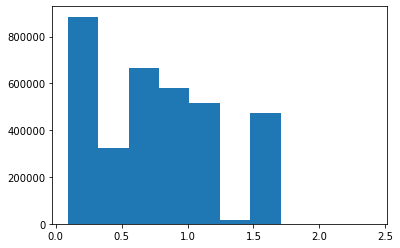

In [29]:
import matplotlib.pyplot as plt
plt.hist(tzeA.equ)

<AxesSubplot:>

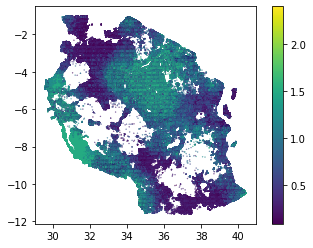

In [30]:
tzeA.plot(column='equ', markersize=0.1, legend=True)
# Stripey area - had to be rearranged first before plotting

(array([2735898.,  313223.,   61409.,  160910.,   26685.,   16673.,
          79834.,   14769.,   59230.,   31786.]),
 array([0.   , 0.455, 0.91 , 1.365, 1.82 , 2.275, 2.73 , 3.185, 3.64 ,
        4.095, 4.55 ]),
 <BarContainer object of 10 artists>)

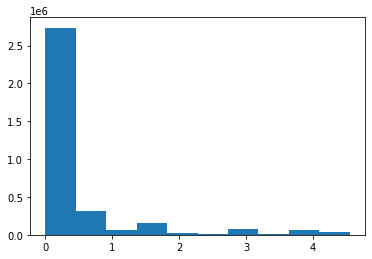

In [31]:
plt.hist(tzeA.volc)

<AxesSubplot:>

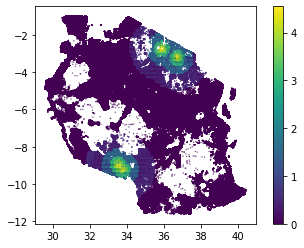

In [32]:
tzeA.plot(column='volc', markersize=0.1, legend=True)

(array([2.989497e+06, 1.392080e+05, 1.860920e+05, 7.682200e+04,
        4.610100e+04, 2.522000e+04, 2.018300e+04, 1.724400e+04,
        1.900000e+01, 3.100000e+01]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

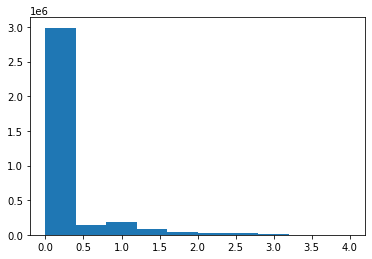

In [33]:
plt.hist(tzeA.flood)

<AxesSubplot:>

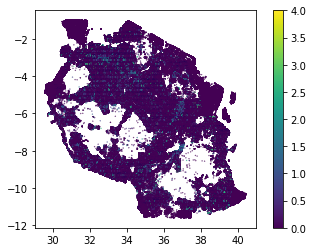

In [34]:
tzeA.plot(column='flood', markersize=0.1, legend=True)

In [35]:
np.sum(np.isnan(tzeA.volc))

0

(array([1.461430e+06, 1.229758e+06, 3.917300e+05, 2.393930e+05,
        7.626300e+04, 3.964500e+04, 1.543700e+04, 5.541000e+03,
        9.290000e+02, 1.220000e+02]),
 array([0.0315 , 0.30155, 0.5716 , 0.84165, 1.1117 , 1.38175, 1.6518 ,
        1.92185, 2.1919 , 2.46195, 2.732  ]),
 <BarContainer object of 10 artists>)

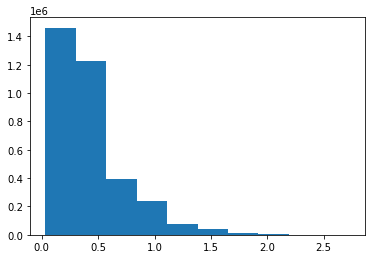

In [36]:
plt.hist(tzeA.hmap)

<AxesSubplot:>

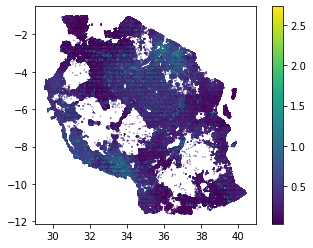

In [37]:
tzeA.plot(column='hmap', markersize=0.1, legend=True)


In [38]:
tzeA.columns

Index(['POINT_X', 'POINT_Y', 'REGION', 'DISTRICT', 'WARD', 'WARD_CODE',
       'TOT_CNT', 'TOT_SIZE_M', 'TOT_VAL', 'geometry', 'FD', 'FU', 'P', 'plu',
       'flu', 'tep', 'lahar', 'pyro', 'ear', 'flood', 'volcsL', 'lah',
       'volcsP', 'pyr', 'volc', 'tze', 'lon', 'lat', 'PGA_0_1', 'PGA_0_02',
       'PGA01_norm', 'pgaindx', 'equ', 'hmap'],
      dtype='object')

<AxesSubplot:>

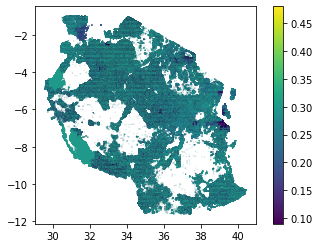

In [39]:
tzeA.plot(column='ear', markersize=0.01, legend=True)

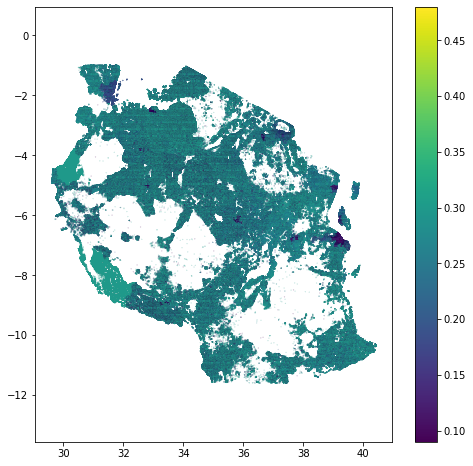

In [40]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='ear', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

C:\Users\KLE\Anaconda3\envs\meteor\lib\site-packages\geopandas\plotting.py:565: FutureWarning: 'axes' is deprecated, please use 'ax' instead (for consistency with pandas)
  warnings.warn(


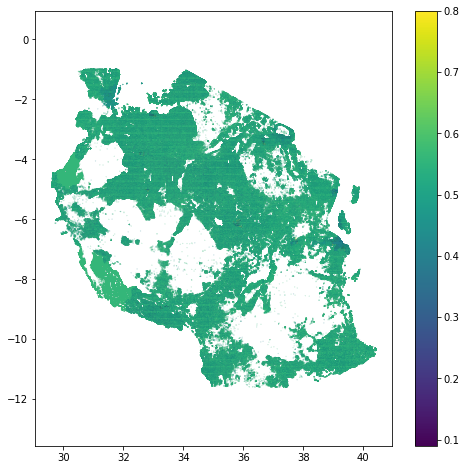

In [41]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(axes=ax, column='plu', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

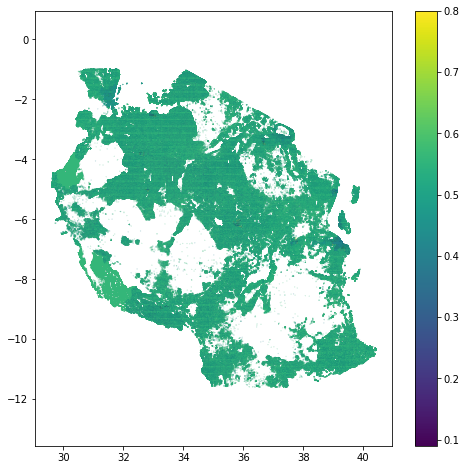

In [42]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='flu', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

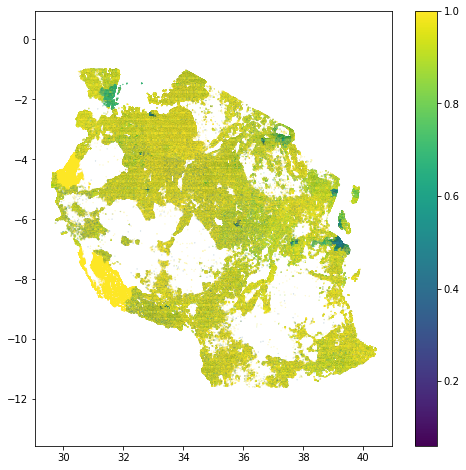

In [43]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='lahar', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

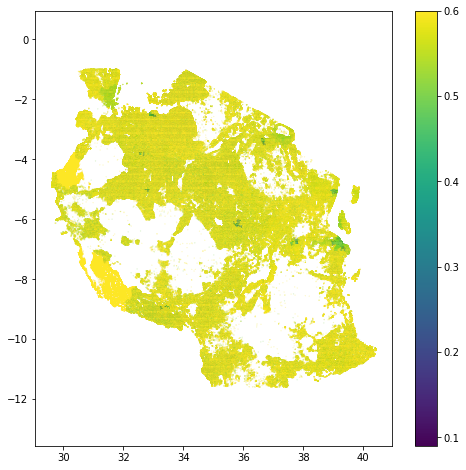

In [44]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='tep', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

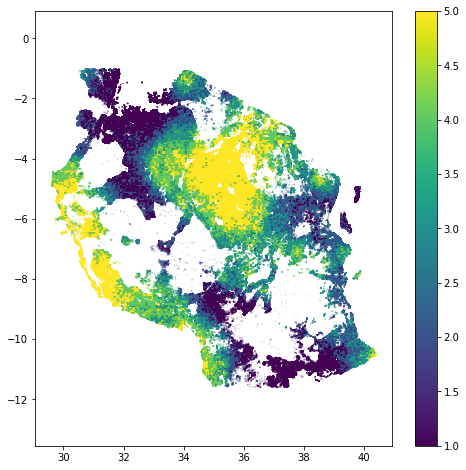

In [45]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='pgaindx', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

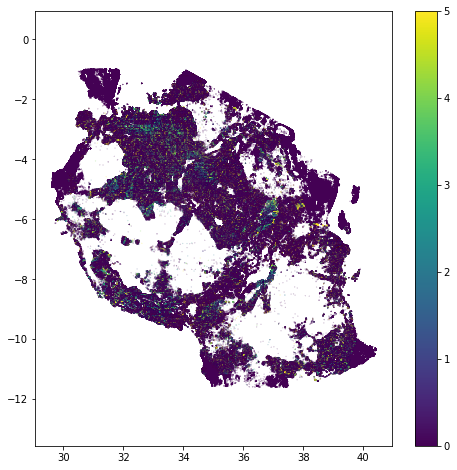

In [46]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='P', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

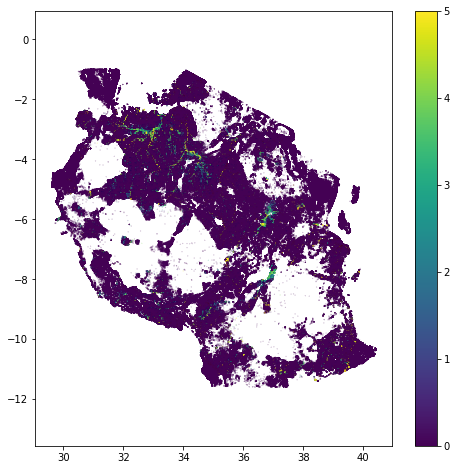

In [47]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='FU', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

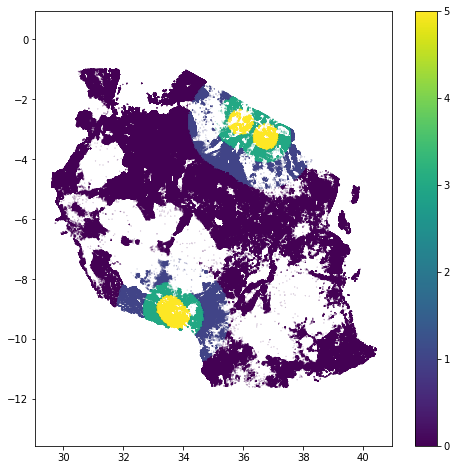

In [48]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='lah', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

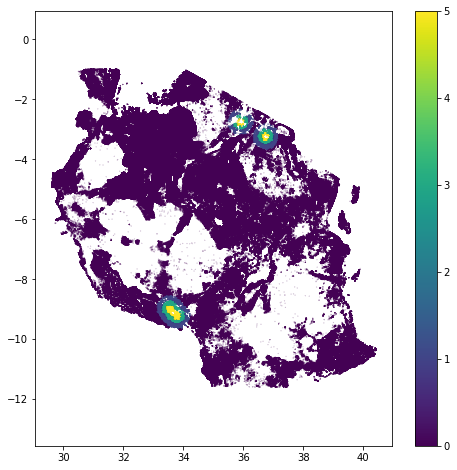

In [49]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='pyr', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

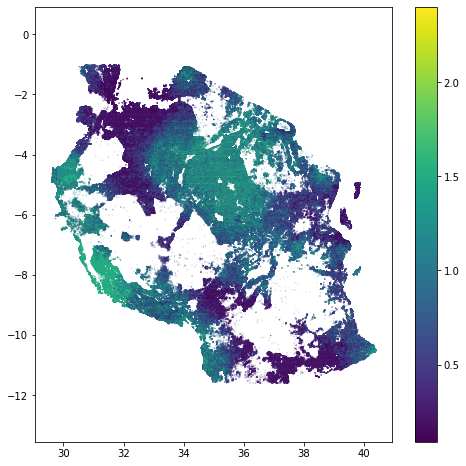

In [50]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='equ', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

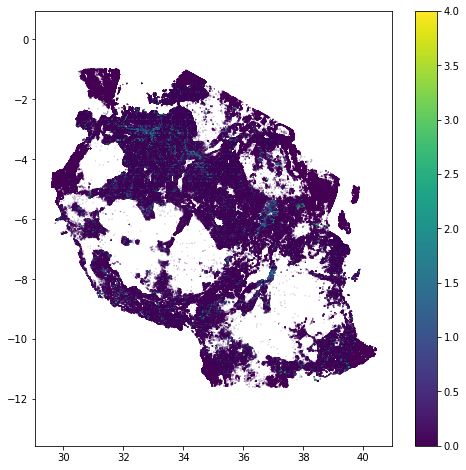

In [51]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='flood', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

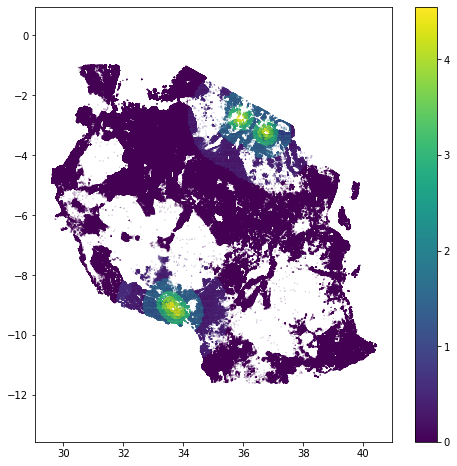

In [52]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='volc', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()

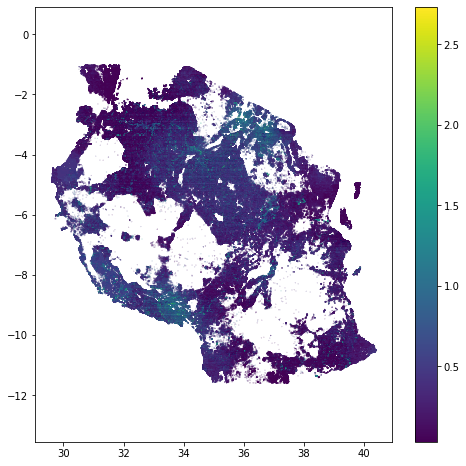

In [53]:
f, ax = plt.subplots(1, figsize=(8, 8))
ax = tzeA.plot(ax=ax, column='hmap', markersize=0.01, legend=True)
lims = plt.axis('equal')
plt.show()